<a href="https://colab.research.google.com/github/PawelJakubczyk/ml_data_preprocessing_utilities/blob/main/ml_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup: Install Required Libraries

In [47]:
%pip install numpy
%pip install pandas
%pip install language_tool_python
%pip install textaugment

# Import Libraries

In [48]:
# Read manage data
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

# Data Preprocesing
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from re import sub, findall
import string
import nltk
import spacy
from language_tool_python import LanguageTool
from collections import Counter

# data augmentation
from textaugment import Wordnet

# Data Analiss
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Define Functions

## Preprocesing

1. **normalize_text(input_text: str) -> str**:
   This function normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces.

2. **remove_punctuation(input_string: str) -> str**:
   This function removes punctuation marks from the input string.

3. **replace_tabs_enters_and_spaces(input_string:str) -> str**:
   This function takes an input string and replaces tabs with a single space and multiple consecutive spaces with a single space.

4. **remove_html_tags(input_text: str) -> str**:
   This function removes HTML tags from the input text.

5. **remove_stopwords(input_string: str, stop_words: Set[str]) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

6. **lemmatize(text: str) -> str**:
   This function lemmatizes the input text. Lemmatization is similar to stemming but considers the context of the word to determine its base or dictionary form.

7. **stemming(text: str) -> str**:
   This function performs stemming on the input text. Stemming reduces words to their root or base form, often by removing suffixes.

    **Note:** It is recommended to avoid using lemmatization (`lemmatize`) and stemming (`stemming`) simultaneously, as both methods serve to normalize words but in different ways. Using them together may lead to excessive text processing and loss of semantic information.

8. **remove_pos_tags(text: str) -> str**:
   This function removes all words from the input text except for nouns (NN). It relies on part-of-speech tagging to identify and retain only nouns in the text.

9. **correct_grammar(text: str) -> str**:
    This function corrects grammar mistakes in the input text.

10. **remove_common_words(text: str, common_threshold: int) -> str**:
    This function removes words from the text that occur too frequently.

11. **remove_rare_words(text: str, rare_threshold: int) -> str**:
    This function removes words from the text that occur too rarely.

12. **clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame**:
    Cleans the input DataFrame by removing rows with missing value or empty strings.



In [49]:
# Prior to running the functions, required resources need to be downloaded
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
STOP_WORDS = nlp.Defaults.stop_words
stemmer = PorterStemmer()
tool = LanguageTool('en-US')

def normalize_text(input_text: str) -> str:
    """Normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces."""
    # Convert to lowercase
    normalized_text = input_text.lower()

    # Remove leading and trailing whitespaces
    normalized_text = normalized_text.strip()

    return normalized_text

def remove_punctuation(input_string: str) -> str:
    """Removes punctuation from the input string"""
    return input_string.translate(str.maketrans('', '', string.punctuation))

def replace_tabs_enters_and_spaces(input_string:str) -> str:
    """Replaces tabs with a single space and multiple spaces with a single space in the input string"""
    replaced_tabs = sub(r'\t', ' ', input_string)
    replace_enters = sub(r'\n', ' ', replaced_tabs)
    replaced_spaces = sub(r'\s+', ' ', replace_enters)
    return replaced_spaces

def remove_html_tags(input_text: str) -> str:
    """Removes HTML tags from the input text."""
    clean_text = sub(r'<.*?>', '', input_text)
    return clean_text

def remove_stopwords(input_string: str) -> str:
    """Removes stopwords from the input string"""
    words = input_string.split()
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    return ' '.join(filtered_words)

def lemmatize(input_string: str)-> str:
    """Lemmatizes the input text"""
    doc = nlp(input_string)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    return ' '.join(sent)

def stemming(input_string: str)-> str:
    """Performs stemming on the input text"""
    tokens = word_tokenize(input_string)
    stem_words = [stemmer.stem(word) for word in tokens]
    return ' '.join(stem_words)

def remove_pos_tags(input_string: str)-> str:
    """Removes all words except nouns (NN) from the input text"""
    doc = nlp(input_string)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

def correct_grammar(text: str) -> str:
    """Corrects grammar mistakes in the input text."""
    corrected_text = tool.correct(text)
    return corrected_text

def remove_common_words(df: pd.DataFrame, column_name: str, common_threshold: int) -> pd.DataFrame:
    """Removes common words from the text in the specified DataFrame column."""
    words = df[column_name].str.lower().str.findall(r'\b\w+\b').sum()
    word_counts = Counter(words)
    common_words = {word for word, count in word_counts.items() if count > common_threshold}
    df[column_name] = df[column_name].apply(lambda text: ' '.join(word for word in text.split() if word.lower() not in common_words))
    return df

def remove_rare_words(df: pd.DataFrame, column_name: str, rare_threshold: int) -> pd.DataFrame:
    """Removes rare words from the text in the specified DataFrame column."""
    words = df[column_name].str.lower().str.findall(r'\b\w+\b').sum()
    word_counts = Counter(words)
    rare_words = {word for word, count in word_counts.items() if count <= rare_threshold}
    df[column_name] = df[column_name].apply(lambda text: ' '.join(word for word in text.split() if word.lower() not in rare_words))
    return df

def clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame:
    """Cleans the input DataFrame by removing rows with incorrect or invalid values."""
    # Make a copy to avoid modifying the original DataFrame
    cleaned_df = df.copy()

    for column in columns_to_check:
        cleaned_df = cleaned_df[cleaned_df[column].notna()]
        cleaned_df = cleaned_df[cleaned_df[column] != ""]

    return cleaned_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Augumentation

1. **augment_data(data, topic_col, text_col) -> DataFrame**:
Data augmentation is a technique used to artificially increase the size of a dataset by creating modified versions of existing data samples. The `augment_data` function implements this technique by generating additional samples for underrepresented topics in the input data.

In [50]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def augment_data(data: pd.DataFrame, topic_col: str, text_col: str) -> pd.DataFrame:
    """Augments the input data by generating additional samples for underrepresented topics."""

    topic_counts = data[topic_col].value_counts()  # get the topic counts
    max_count = topic_counts.max()  # max items for main topic

    augmented_data = []
    wordnet_aug = Wordnet(v=True)  # use Wordnet for synonyms

    # Loop through each topic to create additional data
    for topic, count in topic_counts.items():
        # Get data corresponding to the current topic
        topic_data = data[data[topic_col] == topic]

        # Calculate the number of additional samples needed for this topic
        samples_needed = max_count - count

        # Perform augmentation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            # Augment a randomly selected text from the current topic
            augmented_sentence = wordnet_aug.augment(topic_data[text_col].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)

        # Create a new DataFrame with merged newly created samples and topics
        augmented_df = pd.DataFrame({topic_col: [topic] * len(augmented_sentences),
                                      text_col: augmented_sentences})

        # Add the augmented samples to the list
        augmented_data.append(augmented_df)

    # Merge the newly created DataFrame with samples and the original data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

    # Return the augmented data
    return augmented_data


def augment_data(data: pd.DataFrame, topic_col: str, text_col: str) -> pd.DataFrame:
    """Augments the input data by generating additional samples for underrepresented topics."""

    topic_counts = data[topic_col].value_counts()  # get the topic counts
    max_count = topic_counts.max()  # max items for main topic

    augmented_data = []
    wordnet_aug = Wordnet(v=True)  # use Wordnet for synonyms

    # Loop through each topic to create additional data
    for topic, count in topic_counts.items():
        # Get data corresponding to the current topic
        topic_data = data[data[topic_col] == topic]

        # Calculate the number of additional samples needed for this topic
        samples_needed = max_count - count

        # Perform augmentation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            # Augment a randomly selected text from the current topic
            augmented_sentence = wordnet_aug.augment(topic_data[text_col].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)

        # Create a new DataFrame with merged newly created samples and topics
        augmented_df = pd.DataFrame({topic_col: [topic] * len(augmented_sentences),
                                      text_col: augmented_sentences})

        # Add the augmented samples to the list
        augmented_data.append(augmented_df)

    # Merge the newly created DataFrame with samples and the original data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

    # Return the augmented data
    return augmented_data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Analysis

1. **analyze_word_frequency_in_df_column(df: pd.DataFrame, column_name: str, top_num: int, mode: str = 'most_common') -> dict**:
   Analyzes the word frequency in the specified DataFrame column and returns either the most common or least common words based on the specified mode.

2. **check_missing_values(df: pd.DataFrame, columns: list) -> None**:
   Checks for missing values in the specified columns of the DataFrame.

In [51]:
def analyze_word_frequency_in_df_column(df: pd.DataFrame, column_name: str, top_num: int, mode: str = 'most_common') -> dict:
    all_text = ' '.join(df[column_name].astype(str).tolist())
    words = word_tokenize(all_text)
    fdist = FreqDist(words)

    if mode == 'most_common':
        most_common_words = dict(fdist.most_common(abs(top_num)))
        return most_common_words
    elif mode == 'least_common':
        least_common_words = dict(fdist.most_common()[-abs(top_num):][::-1])
        return least_common_words
    else:
        raise ValueError("Invalid mode. Please choose 'most_common' or 'least_common'.")

def check_missing_values(df: pd.DataFrame, columns: list)-> None:
    """Check missing values in the DataFrame for the specified columns."""

    missing_values = df[columns].replace("", pd.NA).isnull().sum()
    print(missing_values)

## Tokenize

1. **tokenize_text(input_string: str) -> list**:
   Tokenizes the input string into words.

In [52]:
def tokenize_text(input_string):
    # Tokenize the text into words
    tokens = word_tokenize(input_string)

    return tokens

# Preprocesing usage examples

## 1. **normalize_text(input_text: str) -> str**:
   This function normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces.

In [53]:
# Example 1: Simple text
text1 = "   This is a Sample Text   "
normalized_text1 = normalize_text(text1)
print("Original Text 1:", text1)
print("Normalized Text 1:", normalized_text1)

# Example 2: Text with uppercase letters
text2 = "HELLO WORLD"
normalized_text2 = normalize_text(text2)
print("Original Text 2:", text2)
print("Normalized Text 2:", normalized_text2)

# Example 3: Text with multiple white spaces
text3 = "   This     is     another    example    "
normalized_text3 = normalize_text(text3)
print("Original Text 3:", text3)
print("Normalized Text 3:", normalized_text3)

Original Text 1:    This is a Sample Text   
Normalized Text 1: this is a sample text
Original Text 2: HELLO WORLD
Normalized Text 2: hello world
Original Text 3:    This     is     another    example    
Normalized Text 3: this     is     another    example


## 2. **remove_punctuation(input_string: str) -> str**:
   This function removes punctuation marks from the input string.

In [54]:
# Example 1: Text with punctuation
text1 = "Hello, World!"
cleaned_text1 = remove_punctuation(text1)
print("Original Text 1:", text1)
print("Cleaned Text 1:", cleaned_text1)

# Example 2: Text with special characters
text2 = "This is a #test with @special characters!"
cleaned_text2 = remove_punctuation(text2)
print("Original Text 2:", text2)
print("Cleaned Text 2:", cleaned_text2)

# Example 3: Mixed text with punctuation and numbers
text3 = "Don't worry, it's just 9:00 AM!"
cleaned_text3 = remove_punctuation(text3)
print("Original Text 3:", text3)
print("Cleaned Text 3:", cleaned_text3)

Original Text 1: Hello, World!
Cleaned Text 1: Hello World
Original Text 2: This is a #test with @special characters!
Cleaned Text 2: This is a test with special characters
Original Text 3: Don't worry, it's just 9:00 AM!
Cleaned Text 3: Dont worry its just 900 AM


## 3. **replace_tabs_enters_and_spaces(input_string:str) -> str**:
   This function takes an input string and replaces tabs with a single space and multiple consecutive spaces with a single space.

In [55]:
input_text = "This\tis\na\tsample\ttext\nwith\ttabs\nand\nnew\tlines."
print("Original Text:")
print(input_text)

processed_text = replace_tabs_enters_and_spaces(input_text)
print("\nProcessed Text:")
print(processed_text)

Original Text:
This	is
a	sample	text
with	tabs
and
new	lines.

Processed Text:
This is a sample text with tabs and new lines.


## 4. **remove_html_tags(input_text: str) -> str**:
   This function removes HTML tags from the input text.


In [56]:
html_text = "<p>This is <b>HTML</b> <i>text</i> with <a href='#'>links</a>.</p>"
cleaned_text = remove_html_tags(html_text)
print("Original HTML Text:")
print(html_text)
print("\nCleaned Text:")
print(cleaned_text)

Original HTML Text:
<p>This is <b>HTML</b> <i>text</i> with <a href='#'>links</a>.</p>

Cleaned Text:
This is HTML text with links.


## 5. **remove_stopwords(input_string: str) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

In [57]:
# Example 1: Simple text with stopwords
text1 = "This is a sample text with some stopwords like the, is, and in"
filtered_text1 = remove_stopwords(text1)
print("Original Text 1:", text1)
print("Filtered Text 1:", filtered_text1)

# Example 2: Text with uppercase stopwords
text2 = "This Text Contains Some UPPERCASE Stopwords LIKE The, IS, And IN"
filtered_text2 = remove_stopwords(text2)
print("Original Text 2:", text2)
print("Filtered Text 2:", filtered_text2)

# Example 3: Text with punctuation and stopwords
text3 = "This, is, a sample; text with 'punctuation' and stopwords: the, is, and, in"
filtered_text3 = remove_stopwords(text3)
print("Original Text 3:", text3)
print("Filtered Text 3:", filtered_text3)

Original Text 1: This is a sample text with some stopwords like the, is, and in
Filtered Text 1: sample text stopwords like the, is,
Original Text 2: This Text Contains Some UPPERCASE Stopwords LIKE The, IS, And IN
Filtered Text 2: Text Contains UPPERCASE Stopwords LIKE The, IS,
Original Text 3: This, is, a sample; text with 'punctuation' and stopwords: the, is, and, in
Filtered Text 3: This, is, sample; text 'punctuation' stopwords: the, is, and,


## 6. **lemmatize(text: str) -> str**:
   This function lemmatizes the input text. Lemmatization is similar to stemming but considers the context of the word to determine its base or dictionary form.

In [58]:
# Example 1: Simple sentence
sentence1 = "The cats are playing in the garden"
lemmatized_sentence1 = lemmatize(sentence1)
print("Original Sentence 1:", sentence1)
print("Lemmatized Sentence 1:", lemmatized_sentence1)

# Example 2: Text with different word forms
sentence2 = "She was running through the fields"
lemmatized_sentence2 = lemmatize(sentence2)
print("Original Sentence 2:", sentence2)
print("Lemmatized Sentence 2:", lemmatized_sentence2)

# Example 3: Text with stopwords
sentence3 = "The quick brown fox jumps over the lazy dog"
lemmatized_sentence3 = lemmatize(sentence3)
print("Original Sentence 3:", sentence3)
print("Lemmatized Sentence 3:", lemmatized_sentence3)


Original Sentence 1: The cats are playing in the garden
Lemmatized Sentence 1: the cat play garden
Original Sentence 2: She was running through the fields
Lemmatized Sentence 2: she run field
Original Sentence 3: The quick brown fox jumps over the lazy dog
Lemmatized Sentence 3: the quick brown fox jump lazy dog


## 8. **stemming(text: str) -> str**:
   This function performs stemming on the input text. Stemming reduces words to their root or base form, often by removing suffixes.

In [59]:
# Example 1: Simple text
text1 = "I love running in the park"
stemmed_text1 = stemming(text1)
print("Original Text 1:", text1)
print("Stemmed Text 1:", stemmed_text1)

# Example 2: Text with past tense verbs
text2 = "She danced gracefully on the stage"
stemmed_text2 = stemming(text2)
print("Original Text 2:", text2)
print("Stemmed Text 2:", stemmed_text2)

# Example 3: Text with plural nouns
text3 = "There are many cats in the neighborhood"
stemmed_text3 = stemming(text3)
print("Original Text 3:", text3)
print("Stemmed Text 3:", stemmed_text3)

Original Text 1: I love running in the park
Stemmed Text 1: i love run in the park
Original Text 2: She danced gracefully on the stage
Stemmed Text 2: she danc grace on the stage
Original Text 3: There are many cats in the neighborhood
Stemmed Text 3: there are mani cat in the neighborhood


### **Note:** It is recommended to avoid using lemmatization (`lemmatize`) and stemming (`stemming`) simultaneously, as both methods serve to normalize words but in different ways. Using them together may lead to excessive text processing and loss of semantic information.

## 9. **remove_pos_tags(text: str) -> str**:
   This function removes all words from the input text except for nouns (NN). It relies on part-of-speech tagging to identify and retain only nouns in the text.


In [60]:
# Example 1: Simple sentence with different parts of speech
sentence1 = "The cat is sitting on the mat"
processed_sentence1 = remove_pos_tags(sentence1)
print("Original Sentence 1:", sentence1)
print("Processed Sentence 1:", processed_sentence1)

# Example 2: More complex sentence with various parts of speech
sentence2 = "She walks her dog in the park every morning"
processed_sentence2 = remove_pos_tags(sentence2)
print("Original Sentence 2:", sentence2)
print("Processed Sentence 2:", processed_sentence2)

# Example 3: Sentence with additional punctuation and special characters
sentence3 = "I bought a new car, but it's too expensive!"
processed_sentence3 = remove_pos_tags(sentence3)
print("Original Sentence 3:", sentence3)
print("Processed Sentence 3:", processed_sentence3)

Original Sentence 1: The cat is sitting on the mat
Processed Sentence 1: cat mat
Original Sentence 2: She walks her dog in the park every morning
Processed Sentence 2: dog park morning
Original Sentence 3: I bought a new car, but it's too expensive!
Processed Sentence 3: car


## 10. **correct_grammar(text: str) -> str**:
  This function corrects grammar mistakes in the input text.

In [61]:
# Example 1: Correcting a sentence with a grammar mistake
text1 = "He hav a good day."
corrected_text1 = correct_grammar(text1)
print("Original Text 1:", text1)
print("Corrected Text 1:", corrected_text1)

# Example 2: Correcting a paragraph with multiple grammar mistakes
text2 = "She walk to the store and buy some apple. Then, she goes home."
corrected_text2 = correct_grammar(text2)
print("Original Text 2:", text2)
print("Corrected Text 2:", corrected_text2)

Original Text 1: He hav a good day.
Corrected Text 1: He had a good day.
Original Text 2: She walk to the store and buy some apple. Then, she goes home.
Corrected Text 2: She walks to the store and buy some apple. Then, she goes home.


## 11. **remove_common_words(text: str, common_threshold: int) -> str**:
  This function removes words from the text that occur too frequently.

In [62]:
# Sample DataFrame
data = {
    'Text': ["the quick brown fox jumps over the lazy dog",
             "this is a simple example text with repeated words words words",
             "apple banana apple banana apple banana cherry cherry cherry cherry",
             "python is a popular programming language",
             "data science is an interdisciplinary field",
             "machine learning algorithms can analyze large datasets",
             "pandas is a Python library for data manipulation",
             "numpy provides support for numerical computations",
             "matplotlib is a plotting library for Python",
             "scikit-learn offers machine learning tools in Python"]
}

df = pd.DataFrame(data)

print(analyze_word_frequency_in_df_column(df, 'Text', 20))

{'is': 5, 'a': 4, 'cherry': 4, 'words': 3, 'apple': 3, 'banana': 3, 'Python': 3, 'for': 3, 'the': 2, 'data': 2, 'machine': 2, 'learning': 2, 'library': 2, 'quick': 1, 'brown': 1, 'fox': 1, 'jumps': 1, 'over': 1, 'lazy': 1, 'dog': 1}


In [63]:
print("Original DataFrame:")
print(df)

# Applying remove_common_words function
cleaned_df = remove_common_words(df, 'Text', 4)

print("\nDataFrame after removing common words:")
print(cleaned_df)


Original DataFrame:
                                                Text
0        the quick brown fox jumps over the lazy dog
1  this is a simple example text with repeated wo...
2  apple banana apple banana apple banana cherry ...
3           python is a popular programming language
4         data science is an interdisciplinary field
5  machine learning algorithms can analyze large ...
6   pandas is a Python library for data manipulation
7  numpy provides support for numerical computations
8        matplotlib is a plotting library for Python
9  scikit-learn offers machine learning tools in ...

DataFrame after removing common words:
                                                Text
0        the quick brown fox jumps over the lazy dog
1  this a simple example text with repeated words...
2  apple banana apple banana apple banana cherry ...
3              python a popular programming language
4            data science an interdisciplinary field
5  machine learning algorithms can anal

## 12. **remove_rare_words(text: str, rare_threshold: int) -> str**:
  This function removes words from the text that occur too rarely.

In [64]:
data = {
    'Text': ["the quick brown fox jumps over the lazy dog",
             "this is a simple example text with repeated words words words",
             "apple banana apple banana apple banana cherry cherry cherry cherry",
             "python is a popular programming language",
             "data science is an interdisciplinary field",
             "machine learning algorithms can analyze large datasets",
             "pandas is a Python library for data manipulation",
             "numpy provides support for numerical computations",
             "matplotlib is a plotting library for Python",
             "scikit-learn offers machine learning tools in Python"]
}

df = pd.DataFrame(data)

print(analyze_word_frequency_in_df_column(df, 'Text', 30, mode="least_common"))

{'in': 1, 'tools': 1, 'offers': 1, 'scikit-learn': 1, 'plotting': 1, 'matplotlib': 1, 'computations': 1, 'numerical': 1, 'support': 1, 'provides': 1, 'numpy': 1, 'manipulation': 1, 'pandas': 1, 'datasets': 1, 'large': 1, 'analyze': 1, 'can': 1, 'algorithms': 1, 'field': 1, 'interdisciplinary': 1, 'an': 1, 'science': 1, 'language': 1, 'programming': 1, 'popular': 1, 'python': 1, 'repeated': 1, 'with': 1, 'text': 1, 'example': 1}


In [65]:
print("Original DataFrame:")
print(df)

cleaned_df = remove_rare_words(df, 'Text', 1)

print("\nDataFrame after removing rare words:")
print(cleaned_df)

Original DataFrame:
                                                Text
0        the quick brown fox jumps over the lazy dog
1  this is a simple example text with repeated wo...
2  apple banana apple banana apple banana cherry ...
3           python is a popular programming language
4         data science is an interdisciplinary field
5  machine learning algorithms can analyze large ...
6   pandas is a Python library for data manipulation
7  numpy provides support for numerical computations
8        matplotlib is a plotting library for Python
9  scikit-learn offers machine learning tools in ...

DataFrame after removing rare words:
                                                Text
0                                            the the
1                             is a words words words
2  apple banana apple banana apple banana cherry ...
3                                        python is a
4                                            data is
5                                   machi

## 13. **clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame**:
  Cleans the input DataFrame by removing rows with missing value or empty strings.

In [66]:
# Create a larger sample DataFrame with missing and empty values
data = {
    'A': [1, 2, None, 4, 5, 6, 7, 8, 9, 10],
    'B': ['foo', '', 'bar', None, 'baz', 'qux', '', 'quux', None, 'corge'],
    'C': ['', 'baz', None, 'qux', 'quux', '', 'corge', 'grault', None, 'garply']
}
df = pd.DataFrame(data)

# Add more rows with missing or empty values
for _ in range(10):
    df = df.append(pd.Series([np.nan] * 3, index=df.columns), ignore_index=True)

# Specify columns to check for missing or empty values
columns_to_check = ['A', 'B', 'C']

# Clean the DataFrame
cleaned_df = clean_empty_data(df, columns_to_check)

# Display the cleaned DataFrame
print(cleaned_df)

      A      B       C
4   5.0    baz    quux
7   8.0   quux  grault
9  10.0  corge  garply


<ipython-input-66-32c8fbc73592>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series([np.nan] * 3, index=df.columns), ignore_index=True)
<ipython-input-66-32c8fbc73592>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series([np.nan] * 3, index=df.columns), ignore_index=True)
<ipython-input-66-32c8fbc73592>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series([np.nan] * 3, index=df.columns), ignore_index=True)
<ipython-input-66-32c8fbc73592>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series([np.nan] * 3, index=df.columns), ignore_index=True)
<ipython

In [67]:
df.head(10)

,A,B,C
0,1.0,foo,
1,2.0,,baz
2,NaN,bar,None
3,4.0,None,qux
4,5.0,baz,quux
5,6.0,qux,
6,7.0,,corge
7,8.0,quux,grault
8,9.0,None,None
9,10.0,corge,garply


In [68]:
cleaned_df.head(10)

,A,B,C
4,5.0,baz,quux
7,8.0,quux,grault
9,10.0,corge,garply


# Augumentation usage example

## 1. **augment_data(data, topic_col, text_col) -> DataFrame**:
Data augmentation is a technique used to artificially increase the size of a dataset by creating modified versions of existing data samples. The `augment_data` function implements this technique by generating additional samples for underrepresented topics in the input data.

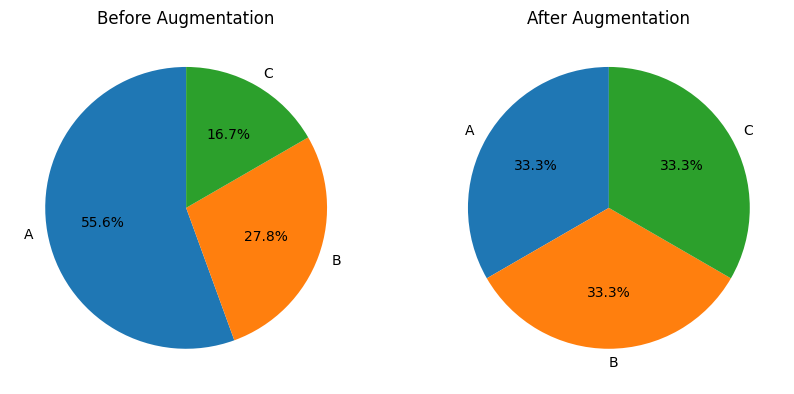

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ... (tutaj wstaw kod dla funkcji augment_data)

# Przykładowe dane
data = {
    'Topic': ['A'] * 10 + ['B'] * 5 + ['C'] * 3,
    'Text': ['TextA'] * 10 + ['TextB'] * 5 + ['TextC'] * 3
}

df = pd.DataFrame(data)

# Przed augmentacją
topic_counts_before = df['Topic'].value_counts()

# Wykres kołowy przed augmentacją
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Before Augmentation')
plt.pie(topic_counts_before, labels=topic_counts_before.index, autopct='%1.1f%%', startangle=90)

# Po augmentacji
augmented_df = augment_data(df, 'Topic', 'Text')
topic_counts_after = augmented_df['Topic'].value_counts()

# Wykres kołowy po augmentacji
plt.subplot(1, 2, 2)
plt.title('After Augmentation')
plt.pie(topic_counts_after, labels=topic_counts_after.index, autopct='%1.1f%%', startangle=90)

plt.show()